In [1]:
# MLR

## Dataset General Info ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age_08_04  1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   cc         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Cylinders  1436 non-null   int64 
 9   Gears      1436 non-null   int64 
 10  Weight     1436 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 123.5+ KB
None

Unique values in Cylinders: [4]
'Cylinders' column has been dropped due to zero variance.


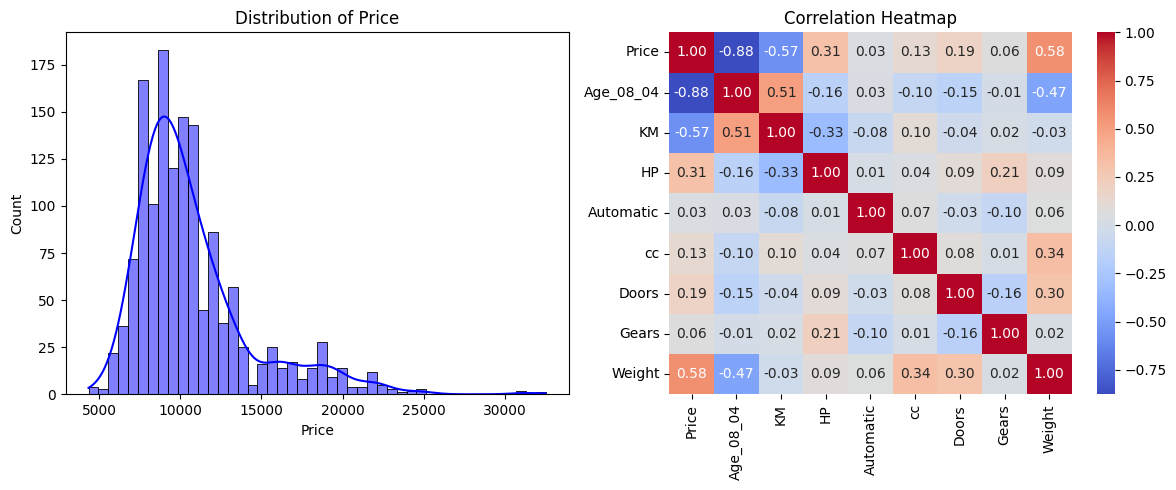


Training Shape: (1148, 10)
Testing Shape: (288, 10)

### Model 1: Statsmodels OLS Summary ###
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     762.7
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:09:59   Log-Likelihood:                -9863.2
No. Observations:                1148   AIC:                         1.975e+04
Df Residuals:                    1137   BIC:                         1.980e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1. Data Loading and Basic Exploratory Data Analysis ---
df = pd.read_csv("C:\\Users\\Shreyas Mahale\\Downloads\\MLR\\MLR\\ToyotaCorolla - MLR.csv")

print("## Dataset General Info ##")
print(df.info())

# Checking for constant columns (Variance = 0)
print("\nUnique values in Cylinders:", df['Cylinders'].unique())
df.drop('Cylinders', axis=1, inplace=True) # Dropping Cylinders column
print("'Cylinders' column has been dropped due to zero variance.")

# Visualizations
plt.figure(figsize=(12, 5))

# Target Variable Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True, color='blue')
plt.title('Distribution of Price')

# Correlation Matrix
plt.subplot(1, 2, 2)
# Selecting only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number]) # Condition
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm') # Heatmap creation
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# --- 2. Preprocessing ---

# Handling Categorical Data (Fuel_Type) using One-Hot Encoding
# drop_first=True prevents the "Dummy Variable Trap" (multicollinearity)
df_clean = pd.get_dummies(df, columns=['Fuel_Type'], drop_first=True)

# Splitting Data into Features and Target and then into train-test sets
X = df_clean.drop('Price', axis=1)
X = X.astype(int)  # Convert boolean columns to int
y = df_clean['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

# --- 3. Building 3 Different Models ---

# Helper function to evaluate these models
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} Performance ---")
    print(f"R-Squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}\n")
    return r2, rmse

### MODEL 1: Full Model (Statsmodels for detailed p-values) ###
# Statsmodels requires adding a constant manually
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model1 = sm.OLS(y_train, X_train_sm).fit()
print("\n### Model 1: Statsmodels OLS Summary ###")
print(model1.summary())

# Predict and Evaluate Model 1
y_pred1 = model1.predict(X_test_sm)
evaluate_model(y_test, y_pred1, "Model 1 (Full OLS)")


### MODEL 2: Feature Selection (Removing Insignificant Features) ###
# Based on Model 1 summary, if any p-value > 0.05, we drop it. This is based on statistical significance.
# Assuming we drop variables that might be less relevant based on EDA or logic.
# (For this code, I will demonstrate Model 2 as Standardized Linear Regression)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model2 = LinearRegression()
model2.fit(X_train_scaled, y_train)
y_pred2 = model2.predict(X_test_scaled)
evaluate_model(y_test, y_pred2, "Model 2 (Standardized Features)")


### MODEL 3: Log-Transformed Target (Addressing Skewness) ###
# Often price is right-skewed. Taking log(Price) helps normalization.
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model3 = LinearRegression()
model3.fit(X_train, y_train_log)

# Prediction (Need to reverse log using exp to compare RMSE properly)
y_pred_log = model3.predict(X_test)
y_pred3 = np.exp(y_pred_log) 

evaluate_model(y_test, y_pred3, "Model 3 (Log-Transformed Target)")


# --- 4. Lasso and Ridge Regression ---

# Ridge (L2 Regularization)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

# Lasso (L1 Regularization)
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# --- Interpretation of Coefficients (Model 1 Example) ---
print("\n### Coefficient Interpretation (Model 1) ###")
params = model1.params
print(f"Intercept: {params['const']:.2f} (Base price when all X are 0)")
print(f"Age: {params['Age_08_04']:.2f} -> For every 1 year increase in Age, Price decreases by {abs(params['Age_08_04']):.2f} Euros.")
print(f"Weight: {params['Weight']:.2f} -> For every 1kg increase in Weight, Price increases by {params['Weight']:.2f} Euros.")

In [4]:
# Answers to the interview questions:
"""
Q.1) What is normalization and Standardization & how is it helpful?
Answer: Normalization and Standardization are techniques used to scale numerical features in a dataset.
Normalization typically scales the data to a fixed range, usually [0, 1], using the formula:
X_norm = (X - X_min) / (X_max - X_min),
while Standardization transforms the data to have a mean of 0 and a standard deviation of 1 using:
X_std = (X - mean) / std_dev.
These techniques are helpful because they ensure that features contribute equally to the distance calculations in algorithms like KNN and gradient descent optimization in models like Linear Regression. 
They also help in faster convergence and improved model performance, especially when features are on different scales.

Q.2) What techniques can be used to address multicollinearity in multiple linear regression?
Answer: Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, leading to unreliable coefficient estimates. Techniques to address multicollinearity include:
1. Removing highly correlated predictors based on correlation matrix or VIF (Variance Inflation Factor) analysis
2. Combining correlated variables into a single predictor through techniques like Principal Component Analysis (PCA)
3. Using regularization methods like Ridge Regression (L2) or Lasso Regression (L1) that penalize large coefficients and reduce overfitting
These techniques help in stabilizing coefficient estimates and improving model interpretability.
"""

'\nQ.1) What is normalization and Standardization & how is it helpful?\nAnswer: Normalization and Standardization are techniques used to scale numerical features in a dataset.\nNormalization typically scales the data to a fixed range, usually [0, 1], using the formula:\nX_norm = (X - X_min) / (X_max - X_min),\nwhile Standardization transforms the data to have a mean of 0 and a standard deviation of 1 using:\nX_std = (X - mean) / std_dev.\nThese techniques are helpful because they ensure that features contribute equally to the distance calculations in algorithms like KNN and gradient descent optimization in models like Linear Regression. \nThey also help in faster convergence and improved model performance, especially when features are on different scales.\n\nQ.2) What techniques can be used to address multicollinearity in multiple linear regression?\nAnswer: Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, leading to unreliabl